# Securing an Atoti session with Auth0 using Google

💡 **Note:** Security implementation is one of the [locked features](https://docs.atoti.io/latest/how_tos/unlock_all_features.html#Unlock-all-features) that are not available in Atoti Community Edition. To try out this notebook, you can request for an [evaluation license](https://atoti.io/evaluation-license-request/) to unlock all features. 

Atoti supports multiple [authentication mechanisms](https://docs.activeviam.com/products/atoti/python-sdk/0.9.6/api/atoti.security.html) to cater to the needs of our end users. Securing a session comes in two parts:

1. Implementing authentication mechanism to secure access to the session
2. Restricting access of modules or data access by users based on the roles granted

This notebook demonstrates how we use [OpenID Connect (OIDC)](https://openid.net/connect/) through [Google Cloud credentials](https://cloud.google.com/docs/authentication) to authenticate access to Atoti web application. We will explore the Atoti security features using the [Top 50 Fast Food](https://www.kaggle.com/datasets/stetsondone/top50fastfood) dataset from Kaggle, combined with its parent company information sourced from the internet.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=oidc-google" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try atoti"></a></div>

## Import libraries

In [1]:
import os
import atoti as tt
import requests
from requests.auth import HTTPBasicAuth
from urllib.parse import urlparse

## Setting up Google Cloud OIDC

Google Cloud APIs use the [OAuth 2.0 protocol](https://tools.ietf.org/html/rfc6749) for authenticating the user accounts. We demonstrate below how we configure the authentication parameter of [`atoti.Session`](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.__init__) to connect Google Cloud Credential API using OIDC.

First, we have to configure the *OAuth consent screen* and register our app. Remember to set the `User type` to `Internal`, so that our app is limited to Google Workspace users within our organization.  

<img src="https://data.atoti.io/notebooks/security/img/google-oauth-consent-screen.png" width="70%" />

Proceed to *APIs & Services* > *Credentials* > *Create credentials* in Google Cloud. Create a credential of type `OAuth client ID` and set the following environment variables for your corresponding client ID and client secret.

For Linux/macOS users:

```bash
export GOOGLE_CLIENT_ID=
export GOOGLE_CLIENT_SECRET=
```

For Windows users:

```bash
set GOOGLE_CLIENT_ID=
set GOOGLE_CLIENT_SECRET=
```

<img src="https://data.atoti.io/notebooks/security/img/google-setup.png" width="70%" />

Set the following URLs. This will configure the authorized redirect URIs for the OAuth 2.0 Client ID in Google Cloud. In Google Cloud, we set the following redirect URI with the [provider_id](https://docs.activeviam.com/products/atoti/python-sdk/0.9.6/api/atoti.OidcConfig.html#atoti.OidcConfig.provider_id) set to `google`: 

```python
f"{session_url}/login/oauth2/code/{provider_id}"
```

* Authorized JavaScript origins
  * `http://localhost:10011`
* Authorized redirect URIs
  * `http://localhost:10011/login/oauth2/code/google`
  * `http://localhost:10011`

<img src="https://data.atoti.io/notebooks/security/img/google-application-url.png" width="70%" />  


## Setting up Atoti

Now that the Google OIDC is configured, we need to set up Atoti to use the Google OIDC authentication.

### Instantiate Atoti session

It is important to set the port for the Atoti session as it needs to match the authorized redirect URIs for the OAuth 2.0 Client ID that we configured in Google Cloud.

During the initial setup, it is also useful to configure the [Spring Security logging](https://www.baeldung.com/spring-security-enable-logging) to help in debugging any potential issues in the connectivity. As shown in the above code snippet, we can turn on logging with `logging.level.org.springframework.security` set to the `DEBUG` level using the `java_options`.

Client IDs and secrets should be kept private. As suggested in the [documentation](https://docs.activeviam.com/products/atoti/python-sdk/0.9.6/guides/securing_a_session.html#Configuring-authentication), connection details can be read from environment variables for improved security.  

In [2]:
authentication = tt.OidcConfig(
    provider_id="google",
    issuer_url="https://accounts.google.com",
    client_id=os.environ["GOOGLE_CLIENT_ID"],
    client_secret=os.environ["GOOGLE_CLIENT_SECRET"],
    scopes={"openid", "email", "profile"},
    name_claim="email",
)

session = tt.Session.start(
    tt.SessionConfig(
        port=10011,
        security=tt.SecurityConfig(sso=authentication),
        user_content_storage="./content-03",
        java_options=["-Dlogging.level.org.springframework.security=DEBUG"],
    )
)

Once the session is created, we can proceed with the usual data loading into Atoti table, cube and measures creation.

### Create table and load data

Although we can use [create table](https://docs.activeviam.com/products/atoti/python-sdk/0.9.6/api/atoti.Session.create_table.html) and then subsequently load data into the table, we use [read_csv](https://docs.activeviam.com/products/atoti/python-sdk/0.9.6/api/atoti.Session.read_csv.html) in our example to create an Atoti table and load data into it in a single operation.

In [3]:
base_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/security/data/parent_co.csv",
    table_name="parent_co",
    keys=["company", "parent_company"],
    process_quotes=True,
)
base_tbl.head()

name
parent_company                 company                                  
Inspire Brands                 arbys                              Arby's
Culver Franchising System, LLC culvers                          Culver's
Papa Murphy's Holdings, Inc.   papa_murphys                Papa Murphy's
Tropical Smoothie Cafe, LLC    tropical_smoothie  Tropical Smoothie Café
Focus Brands                   auntie_annes                Auntie Anne's

In [4]:
enrichment_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/security/data/top_50_fast_food_US.csv",
    table_name="top_50",
    keys=["company"],
)
enrichment_tbl.head()

category  sales_in_millions_2019  \
company                                           
kfc             chicken                    4820   
five_guys        burger                    1662   
moes             global                     785   
sonic_drive_in   burger                    4687   
raising_canes   chicken                    1466   

                sales_per_unit_thousands_2019  franchised_units_2019  \
company                                                                
kfc                                      1196                   4009   
five_guys                                1359                    872   
moes                                     1095                    719   
sonic_drive_in                           1320                   3329   
raising_canes                            3208                     86   

                company_owned_units_2019  total_units_2019  \
company                                                      
kfc                                   56              4065   
five_guys                            496              1368   
moes                                   3               722   
sonic_drive_in                       197              3526   
raising_canes                        371               457   

                unit_change_from_2018  
company                                
kfc                                -9  
five_guys                          10  
moes                                3  
sonic_drive_in                    -74  
raising_canes                      57

In [5]:
base_tbl.join(enrichment_tbl)

### Create cube

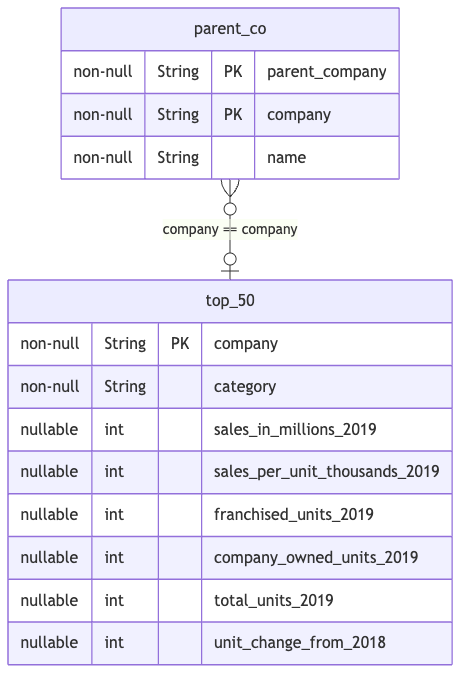

In [6]:
cube = session.create_cube(base_tbl, "Fast food analysis")
session.tables.schema

### Create measures

In [7]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [8]:
m["sales_in_millions"] = tt.agg.sum(enrichment_tbl["sales_in_millions_2019"])
m["sales_per_unit_thousands"] = tt.agg.sum(
    enrichment_tbl["sales_per_unit_thousands_2019"]
)
m["franchised_units"] = tt.agg.sum(enrichment_tbl["franchised_units_2019"])
m["company_owned_units"] = tt.agg.sum(enrichment_tbl["company_owned_units_2019"])
m["total_units"] = tt.agg.sum(enrichment_tbl["total_units_2019"])
m["unit_change_from_2018"] = tt.agg.sum(enrichment_tbl["unit_change_from_2018"])
m["% franchised"] = m["franchised_units"] / m["total_units"]
m["% franchised"].formatter = "DOUBLE[0.00%]"

## Managing roles in Atoti

Let's create some constants for the user IDs of the users we will be creating.  

In [9]:
ADMIN_USER = "atoti_admin"
ATOTI_USER = "atoti_user"
INSPIRE_USER1 = "Inspire_user1"
INSPIRE_USER2 = "Inspire_user2"
INSPIRE_MANAGER = "Inspire_manager"
RESTAURANT_USER1 = "Restaurant_user1"
RESTAURANT_USER2 = "Restaurant_user2"
RESTAURANT_MANAGER = "Restaurant_manager"

### Atoti reserved roles  

The below roles are reserved in Atoti and should not be altered by users:

* `ROLE_ADMIN`: Able to access all objects in the web application.
* `ROLE_USER`: Able to access all data by default. Access to objects such as dashboards, folders, widgets, etc. is enabled only if sharing access is granted to the role.

💡 **Note:** All users, including the administrator, require the role `ROLE_USER` to be able to access the Atoti UI.

Let's assume the following users have been granted the following roles:

* *atoti_admin*: `ROLE_ADMIN`, `ROLE_USER`
* *atoti_user*: `ROLE_USER`

While both *atoti_admin* and *atoti_user* are able to access all data, *atoti\_admin* is able to access all objects such as folders and dashboards. The *atoti\_user* is only able to access the objects created by the user specifically. Objects created by other users can only be accessed upon granting shared access.

#### Share role configuration 

Before Atoti version `0.8.0`, we assigned the role `ROLE_SHARE` to users in order to be able to let them share objects such as dashboards, folders, widgets and filters.  

💡 **Note:** Both *atoti_admin* and *atoti_user* will not be able to share objects (via the "Share" icon as shown below) unless granted the role `ROLE_SHARE`.  

<img src="https://data.atoti.io/notebooks/security/img/share_function.png" width="50%"/>  

From Atoti version `0.8.0` and onwards, the role `ROLE_SHARE` is removed. Instead, users with the role `ROLE_USER` will have the ability to perform sharing by default.  

<img src="https://data.atoti.io/notebooks/security/img/admin_share.png" width="50%"/>


We can configure the sharing permission from the Atoti Admin UI which is accessible from the link below. To do this, we login with a user that has the role `ROLE_ADMIN` assigned.

In [10]:
session.link / "admin"

http://localhost:10011/admin

#### Create technical users

In case we want to limit the users who has the ability to perform sharing, we can either update the `canShare` permission for `ROLE_USER` to `false` from the Admin UI or we can use the REST API service to do so.  

Let's create a technical user (also called service account) for updating the backend. Atoti automatically enables Basic Authentication on the session even though we are using the OIDC authentication mechanism.

In [11]:
technical_user_name = "ATOTI_TECH_ADMIN"
technical_user_password = "password"

technical_user = session.security.basic_authentication.credentials[
    technical_user_name
] = technical_user_password
session.security.individual_roles[technical_user_name] = {"ROLE_USER", "ROLE_ADMIN"}

In [12]:
url = session.url
port = urlparse(url).port

response = requests.put(
    f"http://localhost:{port}/activeviam/content/rest/v7/files?path=ui/user_roles/ROLE_USER/permissions",
    auth=(technical_user_name, technical_user_password),
    json={
        "content": '{"canShare": false}',
        "owners": ["atoti_admin"],
        "readers": ["ROLE_USER"],
        "overwrite": True,
        "recursive": True,
    },
)

In the event we want to control the sharing rights using roles from Authentication providers, we can create the intended role in the Admin UI. For instance, suppose the role that is supposed to have sharing permission is call `ROLE_SHARE`, we can run the below request to create the role with `canShare` set to `true`.  

In [13]:
response = requests.put(
    f"http://localhost:{port}/activeviam/content/rest/v7/files?path=ui/user_roles/ROLE_SHARE/permissions",
    auth=(technical_user_name, technical_user_password),
    json={
        "content": '{"canShare": true}',
        "owners": [technical_user_name],
        "readers": ["ROLE_USER"],
        "overwrite": True,
        "recursive": True,
    },
)
print(response)

<Response [200]>


Below is what we see in the Admin server:  

<img src="https://data.atoti.io/notebooks/security/img/role_share_permission.png" />  

Now, any users who are assigned the role `ROLE_SHARE` in Atoti will have the ability to perform sharing. We will see later on how we can map the roles from Auth0 to the roles in Atoti.  

### Role creation with restrictions  

Data restriction is based on users' requirements. In our use case, we assumed two groups of users with data access limited to those of their parent company:

* Users belonging to parent company `Inspire Brands`
* Users belonging to parent company `Restaurant Brands International Inc.`

Therefore, we will create two roles to apply the restrictions based on the `parent_company` column from the `parent_co` table. We will define a key that is a tuple, consisting of the name of the table and its column, along with the restricted values imposed on it. 

💡 **Note:**  
* We can skip role creation if there are no restrictions imposed on the role. 
* The value provided under the restrictions is cap-sensitive.

In [14]:
ROLE_INSPIRE = "ATOTI_ROLE_INSPIRE"
ROLE_RESTAURANT = "ATOTI_ROLE_RESTAURANT"

session.tables.restrictions.update(
    {
        ROLE_INSPIRE: (base_tbl["parent_company"] == "Inspire Brands"),
        ROLE_RESTAURANT: (
            base_tbl["parent_company"] == "Restaurant Brands International Inc."
        ),
    }
)

#### Restrict access using a combination of roles

Multiple roles can be assigned to the same user. To demonstrate how the access will change when this happens, we create some other roles that restrict data access by the restaurant category, i.e. column `category` from the table `top_50`.

In [15]:
ROLE_BURGER = "ATOTI_ROLE_BURGER"
ROLE_SANDWICH = "ATOTI_ROLE_SANDWICH"
ROLE_SNACK = "ATOTI_ROLE_SNACK"

session.tables.restrictions.update(
    {
        ROLE_BURGER: enrichment_tbl["category"] == "burger",
        ROLE_SANDWICH: enrichment_tbl["category"] == "sandwich",
        ROLE_SNACK: enrichment_tbl["category"] == "snack",
    }
)

When combined with the restricted role on the `parent_company`, users' access will be further restricted based on the restriction of the added role.  

For instance, users who are assigned the role `ATOTI_ROLE_BURGER` will be able to access all of the data under `burger` category restaurants, regardless of the parent companies. However, when the same user is also granted the role `ATOTI_ROLE_INSPIRE`, then the user can only access data of restaurants under parent company `Inspire Brands` that is of category `burger`. 

### Role assignment in Atoti  

Roles are created and assigned to the users in Atoti and they can be granted without having to restart the application.

#### Assign default roles to authenticated users

We can default the roles such as `ROLE_SHARE` for all users who logged in successfully. We want to prevent unwanted access by people outside of the organization. Therefore, this should only be done when the user type for the app registered under the *OAuth consent screen* is `Internal`. Otherwise, it is better to grant `ROLE_USER` individually to the rightful users in the next step.

💡 **Note:** BE CAREFUL when granting `ROLE_USER` to users by default as users with this role will be able to access the application and the available data.  

In [16]:
session.security.oidc.default_roles.update(["ROLE_SHARE"])

#### Grant roles to users authenticated through Google credential

Instead of mapping the roles from the Authentication Provider as in the case of Auth0, we use the user's email address to map to the assigned Atoti roles.

In [17]:
ROLE_USER = "ROLE_USER"

session.security.oidc.role_mapping.update(
    {
        # Google user id: [Atoti roles]
        "inspire_m@test.com": [ROLE_USER, ROLE_INSPIRE],
        "inspire_user1@test.com": [ROLE_USER, ROLE_INSPIRE, ROLE_BURGER],
        "inspire_user2@test.com": [
            ROLE_USER,
            ROLE_INSPIRE,
            ROLE_SANDWICH,
            ROLE_SNACK,
        ],
        "restaurant_m@test.com": [ROLE_USER, ROLE_RESTAURANT],
        "restaurant_user1@test.com": [
            ROLE_USER,
            ROLE_RESTAURANT,
            ROLE_BURGER,
        ],
        "restaurant_user2@test.com": [
            ROLE_USER,
            ROLE_RESTAURANT,
            ROLE_SANDWICH,
            ROLE_SNACK,
        ],
    }
)

## Testing authentication and authorization

Try out any of these users:

💡 **Note:** We recommend navigating to the Atoti UI in incognito mode so that switching between Google users is more seamless.

* Administrator
  * *atoti_admin*
* Generic user
  * *atoti_user*
* Inspire Brands users
  * *Inspire_user1* (Access for restaurants of category Burger only)
  * *Inspire_user2* (Access for restaurants of category Sandwich and Snack only)
  * *Inspire_manager*
* Restaurant Brands International LLC users
  * *Restaurant_user1* (Access for restaurants of category Burger only)
  * *Restaurant_user2* (Access for restaurants of category Sandwich and Snack only)
  * *Restaurant_manager*

In [18]:
session.link

http://localhost:10011

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=oidc-google" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>